## Traning dynamics

In [2]:
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
# Extraction function
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    res = {}
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            res[tag] = r
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return res
folder_wPAL = Path("/share/home/tj90055/hzt/MLANet_fix/data/tensorboard_dirs/mla_wPAL")
folder_woPAL = Path("/share/home/tj90055/hzt/MLANet_fix/data/tensorboard_dirs/mla_woPAL")
metric = "train_loss_iter_0"
runs_wPAL = []
runs_woPAL = []
for v in folder_wPAL.glob("*"):
    if os.path.isdir(v):
        runs_wPAL.append(tflog2pandas(str(v))[metric])
for v in folder_woPAL.glob("*"):
    if os.path.isdir(v):
        runs_woPAL.append(tflog2pandas(str(v))[metric])
print(len(runs_wPAL), len(runs_woPAL))

/share/home/tj90055/.conda/envs/habitat17/lib/python3.6/site-packages/tensorflow-1.13.1-py3.6-linux-x86_64.egg/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/share/home/tj90055/.conda/envs/habitat17/lib/python3.6/site-packages/tensorflow-1.13.1-py3.6-linux-x86_64.egg/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/share/home/tj90055/.conda/envs/habitat17/lib/python3.6/site-packages/tensorflow-1.13.1-py3.6-linux-x86_64.egg/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it wi

5 5


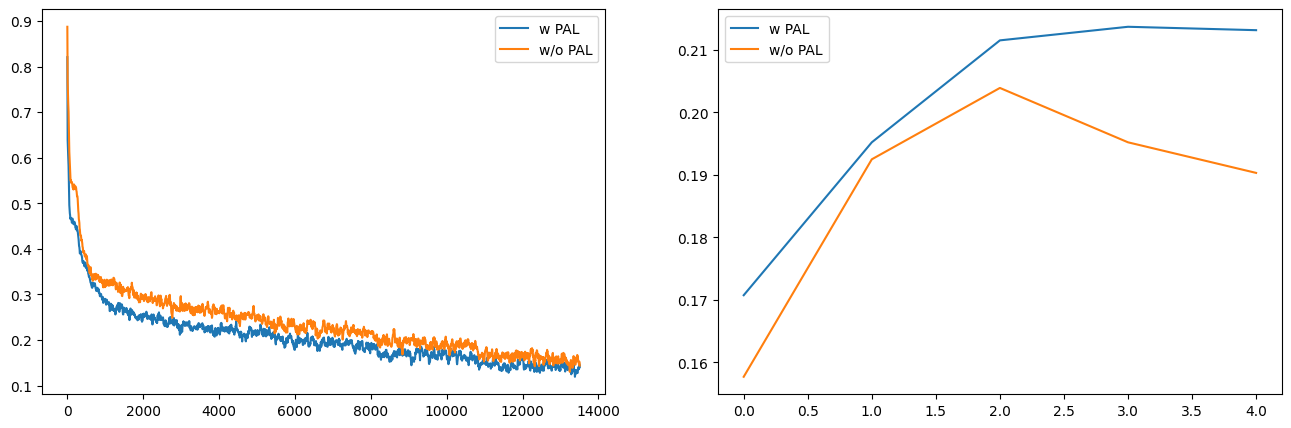

In [ ]:
from scipy.interpolate import make_interp_spline
import math
import json
def smooth_xy(x_value: np.ndarray, y_value: np.ndarray):
    model = make_interp_spline(x_value, y_value)
    x_smooth = np.linspace(x_value.min(), x_value.max(), 500)
    y_smooth = model(x_smooth)
    return x_smooth, y_smooth
def smooth_ewm(df, factor):
    return df.ewm(alpha=(1 - factor)).mean()
def smooth(scalars: list[float], weight: float) -> list[float]:
    """
    EMA implementation according to
    https://github.com/tensorflow/tensorboard/blob/34877f15153e1a2087316b9952c931807a122aa7/tensorboard/components/vz_line_chart2/line-chart.ts#L699
    """
    last = 0
    smoothed = []
    num_acc = 0
    for next_val in scalars:
        last = last * weight + (1 - weight) * next_val
        num_acc += 1
        # de-bias
        debias_weight = 1
        if weight != 1:
            debias_weight = 1 - math.pow(weight, num_acc)
        smoothed_val = last / debias_weight
        smoothed.append(smoothed_val)

    return np.array(smoothed)
color_name='tab20c'
plt.get_cmap(color_name)

smooth_factor = 0.9
downsample = 5
wPAL_coef = 2.4 # 1 action loss, 1 progress loss, 0.4 peak loss
woPAL_coef = 2.0 # 1 action loss, 1 progress loss

i = 4
j = 4
runi = runs_wPAL[i]
runj = runs_woPAL[j]

# run_smooth = smooth_ewm(run, smooth_factor)
x1 = np.array(runi["step"])
y1 = smooth(np.array(runi["value"]), smooth_factor) / wPAL_coef
x2 = np.array(runj["step"])
y2 = smooth(np.array(runj["value"]), smooth_factor) / woPAL_coef
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(x1[::downsample],  y1[::downsample], label='w PAL')
plt.plot(x2[::downsample],  y2[::downsample], label='w/o PAL')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()


plt.subplot(1,2,2)
metric = "success"
split = "val_unseen"

def get_metric(idx, run, metric, split):
    with open("{}_ckpt_{}_{}.json".format(run, idx, split), "r") as f:
        data = json.load(f)
    return data[metric]

sr_wPAL = [get_metric(i, "wPAL", "success", split) for i in range(5)]
sr_woPAL = [get_metric(i, "woPAL", "success", split) for i in range(5)]

plt.plot(sr_wPAL, label='w PAL')
plt.plot(sr_woPAL, label='w/o PAL')
plt.xlabel("Success Rate")
plt.ylabel("Success Rate")
plt.legend()

plt.show()

# for run in runs_woPAL:
#     x1 = np.array(run["step"])
#     y1 = np.array(run["value"])
#     plot0 = plt.plot(x1, y1, color='lightblue')

#     xx, yy = smooth_xy(x1, y1)
#     plot1 = plt.plot(xx, yy, color='teal', label='GO', linewidth=2, linestyle='--')
# plt.plot(go_idx,y1[go_idx-1],'^', color='lightseagreen')

# plt.xlabel('Epoches')
# plt.ylabel('SPL Score')
# plt.legend(loc=4) # 指定legend的位置,读者可以自己help它的用法
# plt.grid()
# plt.tight_layout()
# # plt.savefig("7-a.pdf",bbox_inches="tight")
# plt.show()

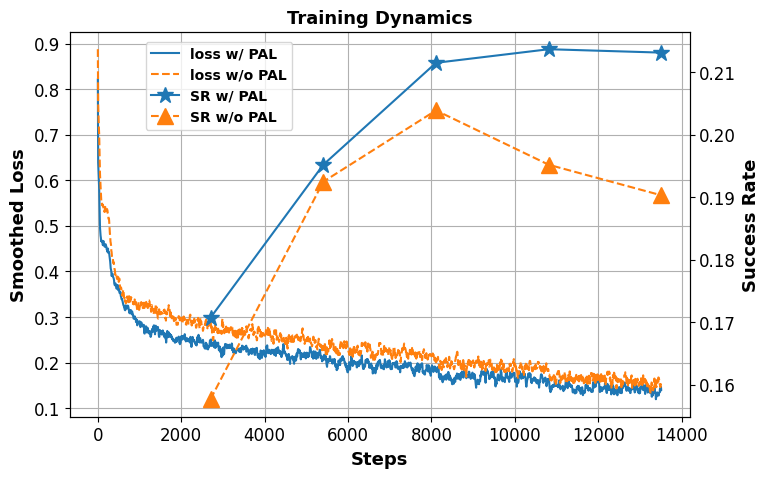

In [ ]:
from scipy.interpolate import make_interp_spline
import math
import json
def smooth_xy(x_value: np.ndarray, y_value: np.ndarray):
    model = make_interp_spline(x_value, y_value)
    x_smooth = np.linspace(x_value.min(), x_value.max(), 500)
    y_smooth = model(x_smooth)
    return x_smooth, y_smooth
def smooth_ewm(df, factor):
    return df.ewm(alpha=(1 - factor)).mean()
def smooth(scalars: list[float], weight: float) -> list[float]:
    """
    EMA implementation according to
    https://github.com/tensorflow/tensorboard/blob/34877f15153e1a2087316b9952c931807a122aa7/tensorboard/components/vz_line_chart2/line-chart.ts#L699
    """
    last = 0
    smoothed = []
    num_acc = 0
    for next_val in scalars:
        last = last * weight + (1 - weight) * next_val
        num_acc += 1
        # de-bias
        debias_weight = 1
        if weight != 1:
            debias_weight = 1 - math.pow(weight, num_acc)
        smoothed_val = last / debias_weight
        smoothed.append(smoothed_val)

    return np.array(smoothed)
color_name='tab20c'
plt.get_cmap(color_name)

smooth_factor = 0.9
downsample = 5
wPAL_coef = 2.4 # 1 action loss, 1 progress loss, 0.4 peak loss
woPAL_coef = 2.0 # 1 action loss, 1 progress loss

i = 4
j = 4
runi = runs_wPAL[i]
runj = runs_woPAL[j]

# run_smooth = smooth_ewm(run, smooth_factor)
x1 = np.array(runi["step"])
y1 = smooth(np.array(runi["value"]), smooth_factor) / wPAL_coef
x2 = np.array(runj["step"])
y2 = smooth(np.array(runj["value"]), smooth_factor) / woPAL_coef
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)
ax1.plot(x1[::downsample],  y1[::downsample], label='loss w/ PAL')
ax1.plot(x2[::downsample],  y2[::downsample], linestyle="--", label='loss w/o PAL')
ax1.set_ylabel("Smoothed Loss", fontsize=13, fontweight='bold')
ax1.set_xlabel("Steps", fontsize=13, fontweight='bold')
ax1.set_title("Training Dynamics", fontsize=13, fontweight='bold')
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
plt.grid(True, linestyle="--")
# plt.legend()

ax2 = ax1.twinx()
metric = "success"
split = "val_unseen"
epoch_steps = 2703*np.array([1,2,3,4,5])-1
def get_metric(idx, run, metric, split):
    with open("{}_ckpt_{}_{}.json".format(run, idx, split), "r") as f:
        data = json.load(f)
    return data[metric]

sr_wPAL = [get_metric(i, "wPAL", "success", split) for i in range(5)]
sr_woPAL = [get_metric(i, "woPAL", "success", split) for i in range(5)]

ax2.plot(epoch_steps, sr_wPAL, marker="*", label='SR w/ PAL', markersize=12)
ax2.plot(epoch_steps, sr_woPAL, marker="^", linestyle="--", label='SR w/o PAL', markersize=11)
plt.yticks(fontsize=12, )
ax2.set_ylabel("Success Rate", fontsize=13, fontweight='bold')
fig.legend(loc="upper left",bbox_to_anchor=(0.22, 0.86), borderaxespad=0.,fontsize=12, prop={'weight':'bold'})

plt.savefig("pal_training_dynamics.pdf", bbox_inches='tight')
plt.savefig("pal_training_dynamics.png", bbox_inches='tight', dpi=300)
plt.show()

In [4]:
def get_merge_df(runs):
    runs_merge = {}
    for i in range(5):
        runs_merge["value_{}".format(i)] = runs[i]["value"]
    runs_merge["step"] = runs[0]["step"]
    runs_merge = pd.DataFrame(runs_merge)
    runs_merge[['mean', 'std']] = runs_merge.filter(like='value_').agg((np.mean, np.std), axis=1)
    return runs_merge
runs_woPAL_merge = get_merge_df(runs_woPAL)
runs_wPAL_merge = get_merge_df(runs_wPAL)
runs_woPAL_merge.head()
runs_wPAL_merge.head()

,value_0,value_1,value_2,value_3,value_4,step,mean,std
0,1.775256,1.779522,2.150294,1.737820,1.970383,0,1.882655,0.174982
1,1.601354,1.519828,1.472119,1.486809,1.509814,2,1.517985,0.050240
2,1.531939,1.555024,1.489230,1.548255,1.484439,3,1.521777,0.033027
3,1.480196,1.488531,1.529527,1.470214,1.455172,5,1.484728,0.027956
4,1.465850,1.454183,1.456885,1.438516,1.438717,7,1.450830,0.011957


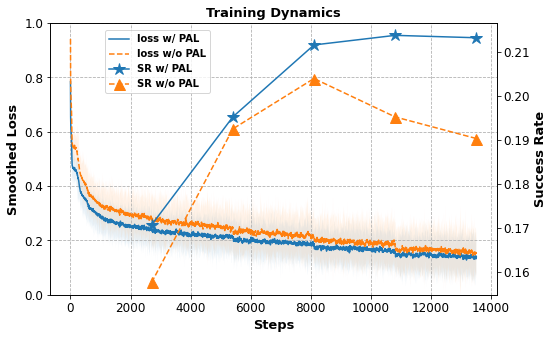

In [23]:
from scipy.interpolate import make_interp_spline
import math
import json
def smooth_xy(x_value: np.ndarray, y_value: np.ndarray):
    model = make_interp_spline(x_value, y_value)
    x_smooth = np.linspace(x_value.min(), x_value.max(), 500)
    y_smooth = model(x_smooth)
    return x_smooth, y_smooth
def smooth_ewm(df, factor):
    return df.ewm(alpha=(1 - factor)).mean()
def smooth(scalars, weight: float):
    """
    EMA implementation according to
    https://github.com/tensorflow/tensorboard/blob/34877f15153e1a2087316b9952c931807a122aa7/tensorboard/components/vz_line_chart2/line-chart.ts#L699
    """
    last = 0
    smoothed = []
    num_acc = 0
    for next_val in scalars:
        last = last * weight + (1 - weight) * next_val
        num_acc += 1
        # de-bias
        debias_weight = 1
        if weight != 1:
            debias_weight = 1 - math.pow(weight, num_acc)
        smoothed_val = last / debias_weight
        smoothed.append(smoothed_val)

    return np.array(smoothed)
color_name='tab20c'
plt.get_cmap(color_name)

smooth_factor = 0.8
downsample = 3
wPAL_coef = 2.4 # 1 action loss, 1 progress loss, 0.4 peak loss
woPAL_coef = 2.0 # 1 action loss, 1 progress loss

i = 4
j = 4
runi = runs_wPAL_merge
runj = runs_woPAL_merge

# run_smooth = smooth_ewm(run, smooth_factor)
x1 = np.array(runi["step"])
y1 = smooth(np.array(runi["mean"]), smooth_factor) / wPAL_coef
# y1 = smooth(np.array(runs_wPAL[4]["value"]), smooth_factor) / wPAL_coef
# y1 = np.array(runi["mean"]) / wPAL_coef
std1 = smooth(np.array(runi["std"]), smooth_factor/2) / wPAL_coef
x2 = np.array(runj["step"])
y2 = smooth(np.array(runj["mean"]), smooth_factor) / woPAL_coef
# y2 = smooth(np.array(runs_woPAL[4]["value"]), smooth_factor) / woPAL_coef
# y2 = np.array(runj["mean"]) / woPAL_coef
std2 = smooth(np.array(runj["std"]), smooth_factor/2) / woPAL_coef
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)
ax1.plot(x1[::downsample],  y1[::downsample], label='loss w/ PAL')
ax1.fill_between(x1[::downsample],y1[::downsample]-3*std1[::downsample],y1[::downsample]+3*std1[::downsample],alpha=.1)
ax1.plot(x2[::downsample],  y2[::downsample], linestyle="--", label='loss w/o PAL')
ax1.fill_between(x2[::downsample],y2[::downsample]-3*std2[::downsample],y2[::downsample]+3*std2[::downsample],alpha=.1)
ax1.set_ylabel("Smoothed Loss", fontsize=13, fontweight='bold')
ax1.set_xlabel("Steps", fontsize=13, fontweight='bold')
ax1.set_title("Training Dynamics", fontsize=13, fontweight='bold')
ax1.set_ylim([0,1.0])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
plt.grid(True, linestyle="--")
# plt.legend()

ax2 = ax1.twinx()
metric = "success"
split = "val_unseen"
epoch_steps = 2703*np.array([1,2,3,4,5])-1
def get_metric(idx, run, metric, split):
    with open("{}_ckpt_{}_{}.json".format(run, idx, split), "r") as f:
        data = json.load(f)
    return data[metric]
def get_metric2(run, metric, split):
    res = np.zeros((5,5))
    for i in range(5):
        for j in range(5):
            with open("{}{}_ckpt_{}_{}.json".format(run, i, j, split), "r") as f:
                data = json.load(f)
            res[i][j] = data[metric]
    res = res.mean(axis=0)
    return res

sr_wPAL = [get_metric(i, "wPAL", "success", split) for i in range(5)]
sr_woPAL = [get_metric(i, "WoPAL4", "success", split) for i in range(5)]

ax2.plot(epoch_steps, sr_wPAL, marker="*", label='SR w/ PAL', markersize=12)
# ax2.errorbar(epoch_steps, sr_wPAL, yerr=0.01, marker="*", label='both limits (default)')
ax2.plot(epoch_steps, sr_woPAL, marker="^", linestyle="--", label='SR w/o PAL', markersize=11)
plt.yticks(fontsize=12, )
ax2.set_ylabel("Success Rate", fontsize=13, fontweight='bold')
fig.legend(loc="upper left",bbox_to_anchor=(0.22, 0.86), borderaxespad=0.,fontsize=12, prop={'weight':'bold'})

plt.savefig("pal_training_dynamics.pdf", bbox_inches='tight')
plt.savefig("pal_training_dynamics.png", bbox_inches='tight', dpi=300)
plt.show()

In [2]:
import nltk
s = "Turn to the right, go past the refrigerator.  Turn left and walk to the point where you're to the hallway by the entry and dining room area."
nltk.sent_tokenize(s)
word_list = nltk.pos_tag(nltk.word_tokenize(s))
for word, pos in word_list:
    print(word, pos)

Turn NN
to TO
the DT
right NN
, ,
go VB
past IN
the DT
refrigerator NN
. .
Turn NNP
left VBD
and CC
walk VB
to TO
the DT
point NN
where WRB
you PRP
're VBP
to TO
the DT
hallway NN
by IN
the DT
entry NN
and CC
dining NN
room NN
area NN
. .


## Significance

In [38]:
import scipy.stats as stats
import json
import matplotlib.pyplot as plt
full_data = []
ablation_data = []
full_name = "../ablate_mla_ttest/Full"
ablation_name = "../ablate_mla_ttest/WoMLAT"
epoch = 4
for i in range(5):
    filename = "{}{}_ckpt_{}_val_unseen.json".format(full_name, i, epoch)
    with open(filename, "r") as f:
        data = json.load(f)
    full_data.append(data["success"])
    filename = "{}{}_ckpt_{}_val_unseen.json".format(ablation_name, i, epoch)
    with open(filename, "r") as f:
        data = json.load(f)
    ablation_data.append(data["success"])

# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(full_data, ablation_data)

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference.")
print(t_stat)
print(p_value)
print(full_data)
print(ablation_data)

Reject the null hypothesis: There is a significant difference.
3.391231979522617
0.009482657502920024
[0.22947253942359977, 0.21315932572050028, 0.19738988580750408, 0.20500271886895052, 0.22947253942359977]
[0.1854268624252311, 0.1821642196846112, 0.188689505165851, 0.1979336595976074, 0.1979336595976074]


In [39]:
import scipy.stats as stats
import json
import matplotlib.pyplot as plt
full_data = []
ablation_data = []
full_name = "../ablate_mla_ttest/Full"
ablation_name = "../ablate_mla_ttest/WoMLAT"
epoch = 4
for i in range(5):
    best = 0
    for epoch in range(5):
        filename = "{}{}_ckpt_{}_val_unseen.json".format(full_name, i, epoch)
        with open(filename, "r") as f:
            data = json.load(f)
        best = max(best, data["success"])
    full_data.append(best)
    best = 0
    for epoch in range(5):
        filename = "{}{}_ckpt_{}_val_unseen.json".format(ablation_name, i, epoch)
        with open(filename, "r") as f:
            data = json.load(f)
        best = max(best, data["success"])
    ablation_data.append(best)

# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(full_data, ablation_data)

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference.")
print(t_stat)
print(p_value)
print(full_data)
print(ablation_data)

Reject the null hypothesis: There is a significant difference.
7.343763949027123
8.042000208694899e-05
[0.22947253942359977, 0.2137030995106036, 0.21914083741163676, 0.22838499184339314, 0.22947253942359977]
[0.19684611201740077, 0.20337139749864055, 0.1952147906470908, 0.1979336595976074, 0.1979336595976074]


In [31]:
import pingouin as pg
import json
import matplotlib.pyplot as plt
full_data = []
ablation_data = []
full_name = "../ablate_mla_ttest/Full"
ablation_name = "../ablate_mla_ttest/WoMLAT"
epoch = 4
for i in range(5):
    best = 0
    for epoch in range(5):
        filename = "{}{}_ckpt_{}_val_unseen.json".format(full_name, i, epoch)
        with open(filename, "r") as f:
            data = json.load(f)
        best = max(best, data["success"])
    full_data.append(best)
    best = 0
    for epoch in range(5):
        filename = "{}{}_ckpt_{}_val_unseen.json".format(ablation_name, i, epoch)
        with open(filename, "r") as f:
            data = json.load(f)
        best = max(best, data["success"])
    ablation_data.append(best)

# Perform an independent t-test
result = pg.ttest(full_data, ablation_data)

t_stat = result["T"].item()
p_value = result["p-val"].item()
print(result)
# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference.")
print(t_stat)
print(p_value)
print(full_data)
print(ablation_data)

               T  dof alternative    p-val         CI95%   cohen-d     BF10  \
T-test  7.343764    8   two-sided  0.00008  [0.02, 0.03]  4.644604  198.789   

           power  
T-test  0.999993  
Reject the null hypothesis: There is a significant difference.
7.343763949027123
8.042000208694899e-05
[0.22947253942359977, 0.2137030995106036, 0.21914083741163676, 0.22838499184339314, 0.22947253942359977]
[0.19684611201740077, 0.20337139749864055, 0.1952147906470908, 0.1979336595976074, 0.1979336595976074]


## Longer sequence

In [ ]:
import numpy as np
import pickle
with open("score_save.pkl", "rb") as f:
    score = pickle.load(f)

import matplotlib.pyplot as plt
import seaborn as sns
for k,v in score.items():
    hm = v["score"]
    v["score"] = v["score"]/ v["score"].sum(keepdims=True, axis=1)
    if hm.shape[0]>100 and v["infos"]["success"]!=1.0:
        print(k)

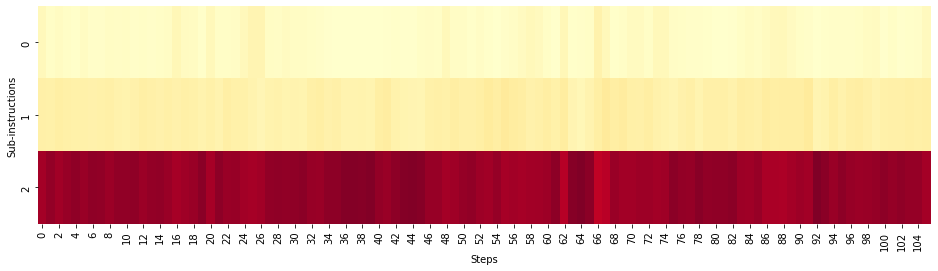

In [ ]:
# 678, 741
plt.figure(figsize=(16,4))
sns.heatmap(
    score[741]["score"].T,
    annot=False,
    fmt=".2f",
    cmap="YlOrRd",
    linewidths=0,
    cbar=False,
)
plt.xlabel("Steps")
plt.ylabel("Sub-instructions")
plt.savefig("tmp.png", dpi=300, bbox_inches="tight")
plt.show()

## Computational efficiency

In [36]:
import json
import numpy as np
split = "val_unseen"
flops = { # GFLOPs
    "CMA": 4.51,
    "MLANet": 11.07,
    "HPN+DN": 28.29
}

with open(f"{split}_Baseline_times.json","r") as f:
    cma_times = json.load(f)[1:]
with open(f"{split}_MLANet_times.json","r") as f:
    mla_times = json.load(f)[1:]
with open(f"{split}_HPNDN_times.json","r") as f:
    way_times = json.load(f)[1:]
times_mean = {
    "CMA": np.mean(cma_times),
    "MLANet": np.mean(mla_times),
    "HPN+DN": np.mean(way_times)
}
times_std = {
    "CMA": np.std(cma_times),
    "MLANet": np.std(mla_times),
    "HPN+DN": np.std(way_times)
}

step_limit = 250
with open(f"{split}_Baseline_stats_episodes.json","r") as f:
    data = json.load(f)
    cma_steps = [v["steps_taken"] for v in data.values() if v["steps_taken"]<=step_limit]
    cma_traj_times = [v["traj_time"] for v in data.values() if v["steps_taken"]<=step_limit]
with open(f"{split}_MLANet_stats_episodes.json","r") as f:
    data = json.load(f)
    mla_steps = [v["steps_taken"] for v in data.values() if v["steps_taken"]<=step_limit]
    mla_traj_times = [v["traj_time"] for v in data.values() if v["steps_taken"]<=step_limit]
with open(f"{split}_HPNDN_stats_episodes.json","r") as f:
    data = json.load(f)
    way_steps = [v["steps_taken"] for v in data.values() if v["steps_taken"]<=step_limit]
    way_traj_times = [v["traj_time"] for v in data.values() if v["steps_taken"]<=step_limit]
steps_mean = {
    "CMA": np.mean(cma_steps),
    "MLANet": np.mean(mla_steps),
    "HPN+DN": np.mean(way_steps)
}
steps_std = {
    "CMA": np.std(cma_steps),
    "MLANet": np.std(mla_steps),
    "HPN+DN": np.std(way_steps)
}
traj_times_mean = {
    "CMA": np.mean(cma_traj_times),
    "MLANet": np.mean(mla_traj_times),
    "HPN+DN": np.mean(way_traj_times)
}
traj_times_std = {
    "CMA": np.std(cma_traj_times),
    "MLANet": np.std(mla_traj_times),
    "HPN+DN": np.std(way_traj_times)
}


srs = { 
    "CMA": 28,
    "MLANet": 34,
    "HPN+DN": 32
}

all_zeros = {
    "CMA": 0,
    "MLANet": 0,
    "HPN+DN": 0
}

metric_list = [flops, times_mean, traj_times_mean, steps_mean, srs]
std_list = [all_zeros, times_std, traj_times_std, steps_std, all_zeros]
scale_factor = [1,1000,10,1,1]

/tmp/ipykernel_433666/4256280117.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


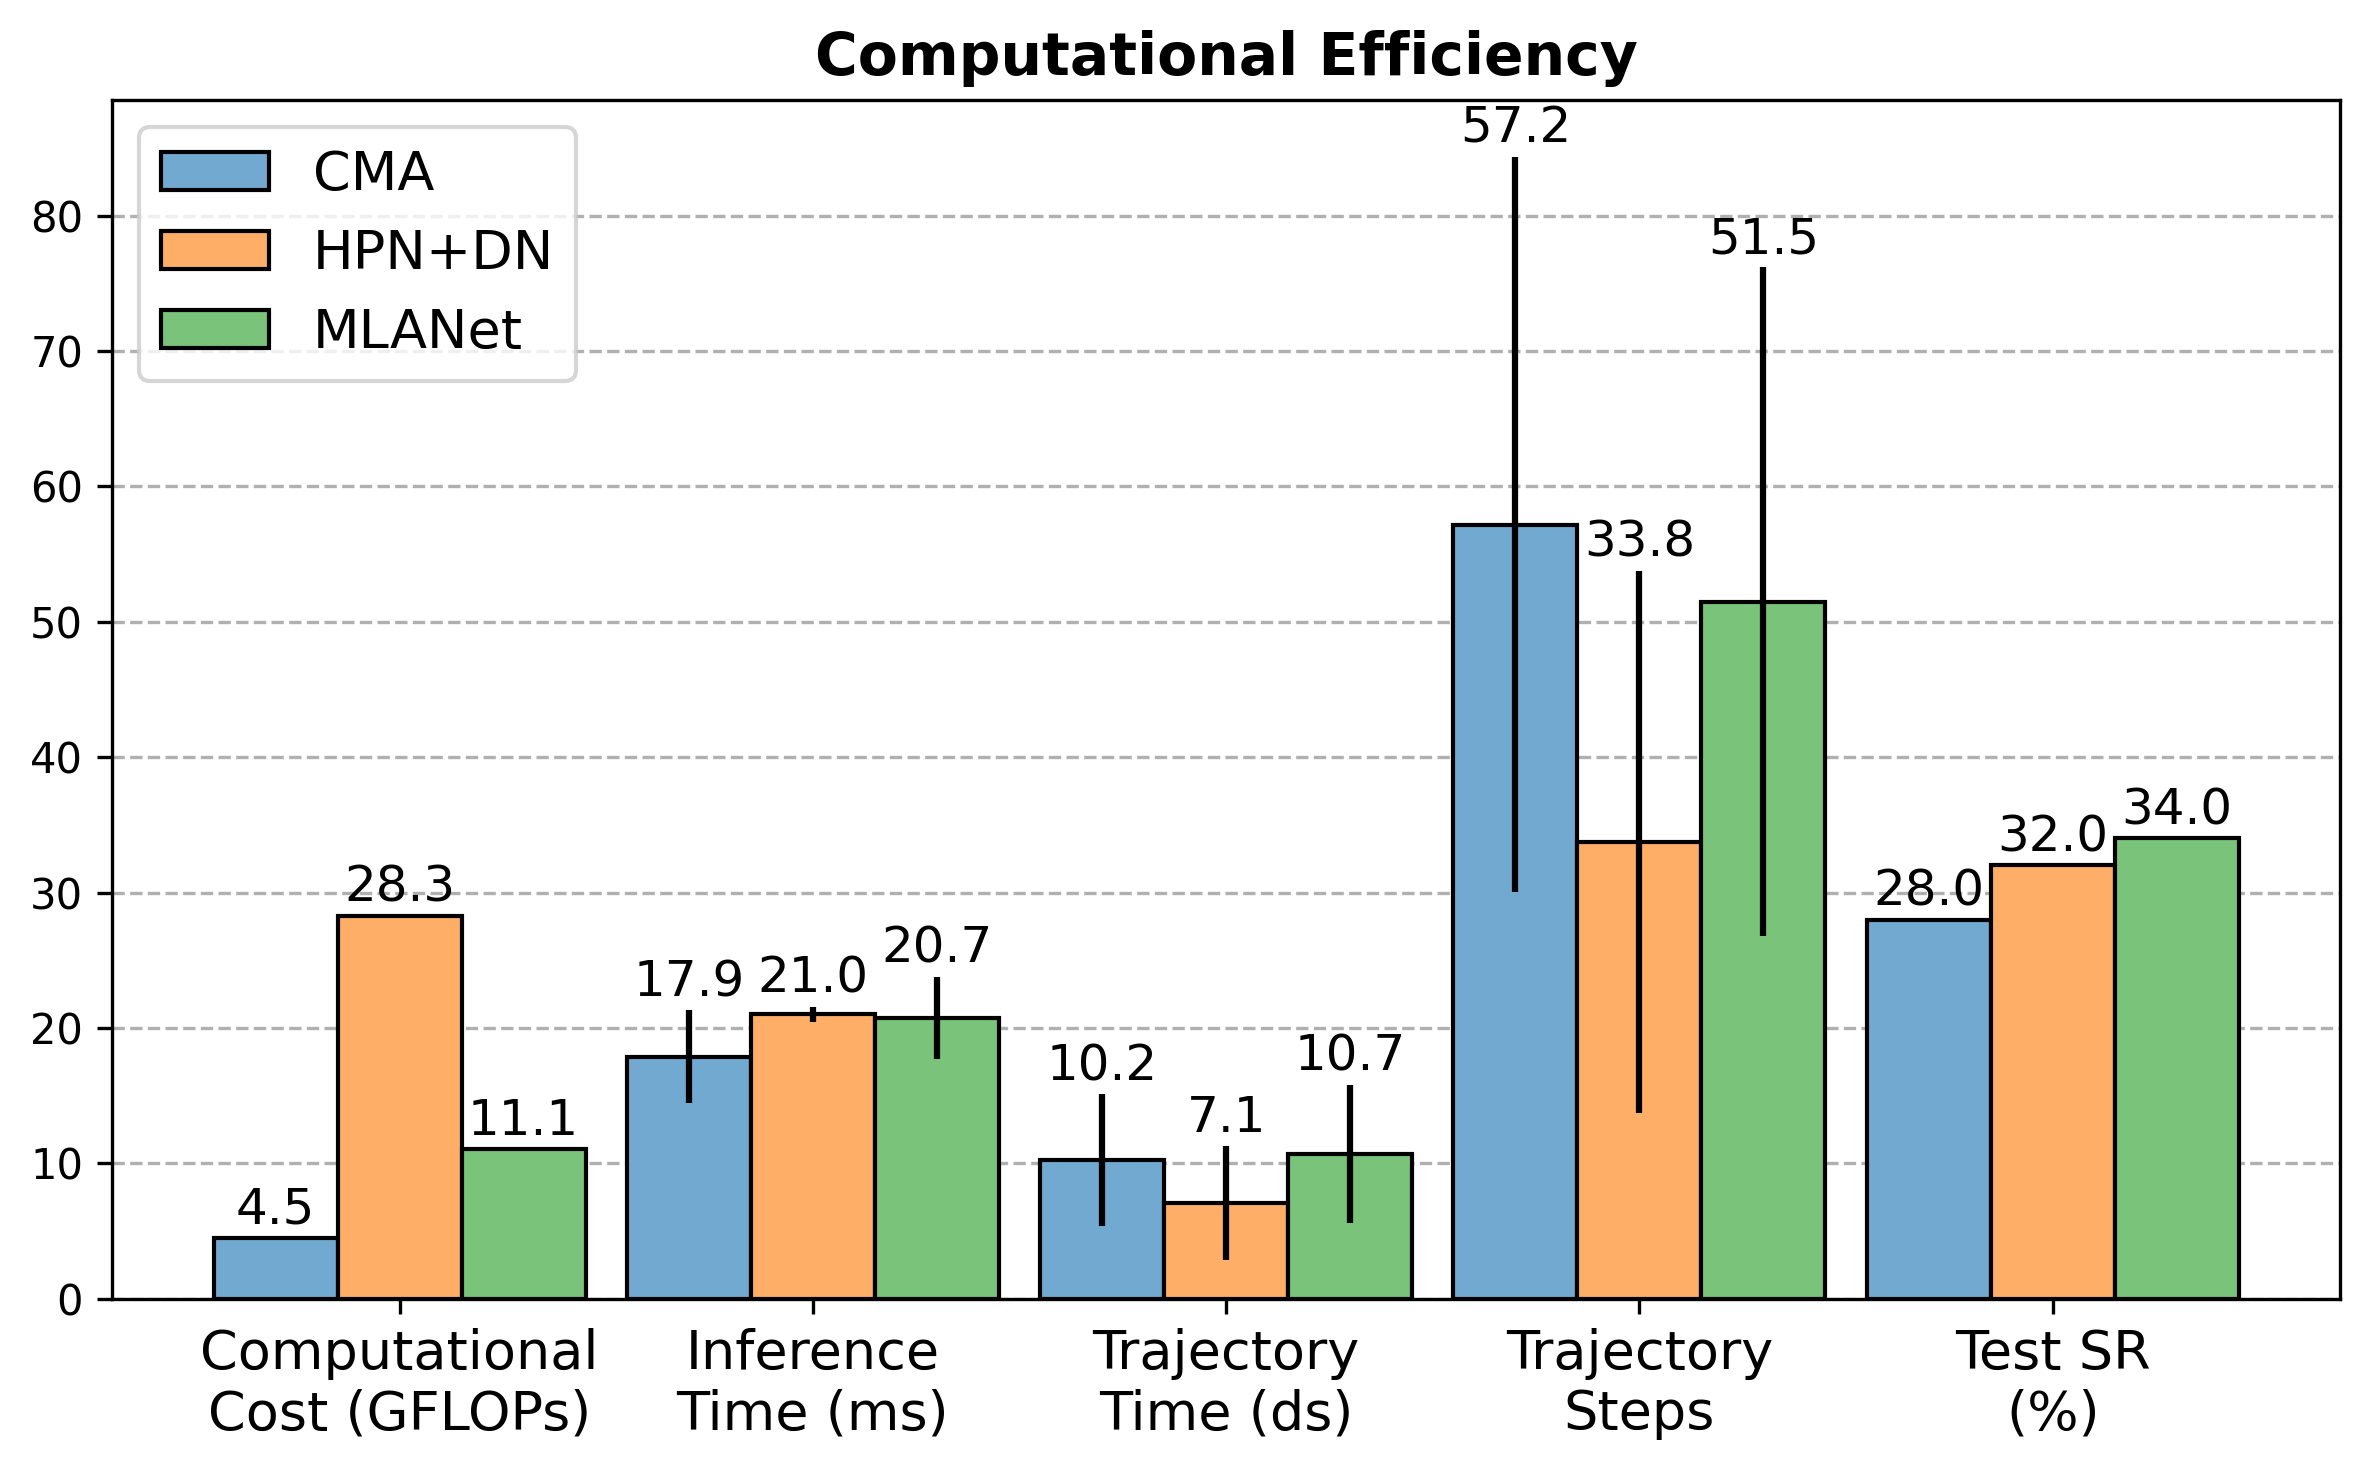

In [37]:
import matplotlib.pyplot as plt
import numpy as np

FS = 14
species = ("Computational\nCost (GFLOPs)", "Inference\nTime (ms)", "Trajectory\nTime (ds)", "Trajectory\nSteps", "Test SR\n(%)")
penguin_means = {
    'CMA': np.array([v["CMA"]*scale_factor[i] for i,v in enumerate(metric_list)]),
    'HPN+DN': np.array([v["HPN+DN"]*scale_factor[i] for i,v in enumerate(metric_list)]),
    'MLANet': np.array([v["MLANet"]*scale_factor[i] for i,v in enumerate(metric_list)]),
}
penguin_stds = {
    'CMA': np.array([v["CMA"]*scale_factor[i] for i,v in enumerate(std_list)]),
    'HPN+DN': np.array([v["HPN+DN"]*scale_factor[i] for i,v in enumerate(std_list)]),
    'MLANet': np.array([v["MLANet"]*scale_factor[i] for i,v in enumerate(std_list)]),
}

x = np.arange(len(species))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',dpi=300, figsize=(8,5))
ax.grid(True, linestyle="--",axis='y')
ax.set_axisbelow(True)
colors = plt.cm.viridis(np.array([0.0, 0.5, 1.0]))
for i in range(3):
    colors[i][3] = 0.5
colors = ['#72a9d0', '#ffae68', '#7ac37a']
for i, (attribute, measurement) in enumerate(penguin_means.items()):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=colors[i], edgecolor="black", yerr=penguin_stds[attribute])
    ax.bar_label(rects, fmt="%.1f", padding=1, fontsize=FS-2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Percentage (%)', fontsize=FS)
ax.set_title('Computational Efficiency', fontsize=FS, fontweight="bold")
ax.set_xticks(x + width, species, fontsize=FS-1)
# ax.set_yticks([])
ax.legend(loc='upper left', ncols=1, prop={'size': FS-1})
# ax.set_ylim(0, 100)
plt.tight_layout()
plt.savefig("computational_efficiency.pdf", dpi=300, bbox_inches="tight")
plt.savefig("computational_efficiency.png", dpi=600, bbox_inches="tight")
plt.show()

In [10]:
print(np.mean(cma_steps),cma_steps[:10])

58.63877266387727 [45.0, 52.0, 44.0, 39.0, 51.0, 61.0, 69.0, 80.0, 60.0, 41.0]
